In [4]:
import scanpy as sc
import matplotlib.pyplot as pl
import seaborn as sns
import pandas as pd
import numpy as np
import sys
import scvelo as scv
from pathlib import Path

# Paths and utils
root = Path('../')
figure_path = root / 'results/figures/Neutrophils/'
figure_path.mkdir(parents=True, exist_ok=True)
table_path = root / 'results/tables/'
signatures_path = root / 'resources/'
import yaml
with open('../configuration/config.yaml', 'r') as file:
    config = yaml.safe_load(file)
data_path = Path(config['data_path'])
# local utils
sys.path.insert(1, '../utils/')
from utils import format_one_pval

# Set plotting style
from matplotlib import rcParams
# Type 2/TrueType fonts
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
# Arial font
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "sans-serif"
%matplotlib inline

# Load data

In [6]:
superdata = sc.read(data_path / "Pancov19_prepd_all.h5")

# Import color options
celltype_colors = config['celltype_colors']
celltype_rough_colors = config['celltype_rough_colors']
organism_colors = config['organism_colors']
organism_dosage_colors = config['organism_dosage_colors']
dosage_colors = config['dosage_colors']

# Newer names, more accurate
organism_rename_dict = {
    'Dwarfhamster': 'Roborovski hamster',
    'Goldhamster': 'Syrian hamster'
}
time_rename_dict = {
    'D0': '0 dpi',
    'D2': '2 dpi',
    'D3': '3 dpi',
    'D5': '5 dpi',
    'E14': '14 dpi'
}
dosage_rename_dict = {
    'no dose': '0 pfu',
    'low dose': r'$1\times10^4$ pfu',
    'high dose': r'$1\times10^5$ pfu'
}

def sanitize_name(s):
    for rdict in [organism_rename_dict, time_rename_dict, dosage_rename_dict]:
        for old, new in rdict.items():
            s = s.replace(old, new)
            
    return s.replace('_', ', ')

from matplotlib.cm import get_cmap
# not super pretty, but ok for now
time_colors = {
    'D0': 'grey',
    'D2': get_cmap('viridis_r')(0),
    'D3': get_cmap('viridis_r')(1/3),
    'D5': get_cmap('viridis_r')(2/3),
    'E14': get_cmap('viridis_r')(1),
              }
    
# Translate color palettes to new names as well
Organism_colors = {sanitize_name(key) : value for key, value in config['organism_colors'].items()}
Organism_Dosage_colors = {sanitize_name(key) : value for key, value in config['organism_dosage_colors'].items()}
Dosage_colors = {sanitize_name(key) : value for key, value in config['dosage_colors'].items()}
Time_colors = {sanitize_name(key) : value for key, value in time_colors.items()}

# define control dicts for DE testing etc.
control_dict = {x: ['pr_D0_Z1_L','pr_D0_Z2_L','pr_D0_Z3_L'] if 'pr' in x else ['ma_d0_lung_1', 'ma_d0_lung_2', 'ma_d0_lung_3'] for x in pd.unique(superdata.obs['orig.ident']) if '0' not in x}
control_dict_odt = {x: 'Dwarfhamster_no dose_D0' if 'Dwarfhamster' in x else 'Goldhamster_no dose_D0' for x in superdata.obs.organism_dosage_time.unique() if 'D0' not in x}

# UMAP of considered celltypes

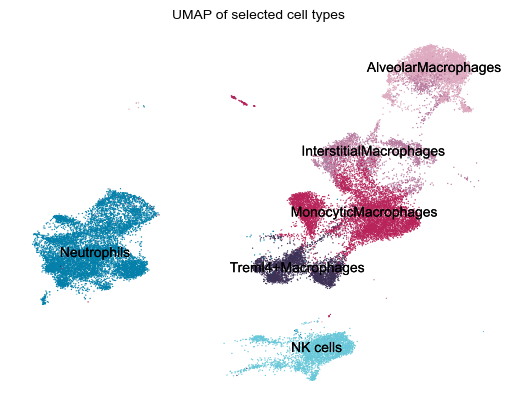

In [7]:
mask = superdata.obs.celltype_rough.isin(['Neutrophils', 'NK cells', 'Macrophages'])
superdata.obs['celltype_'] = superdata.obs.celltype.copy()
superdata.obs['celltype_'][superdata.obs.celltype_rough.isin(['NKT cells', 'NK cells'])] = 'NK cells'
# remove outliers / zoom in
mask = mask & (superdata.obsm['X_umap_scVI'][:, 0] < 8) & (superdata.obsm['X_umap_scVI'][:, 1] > 2)
scv.pl.scatter(superdata[mask], color='celltype_', basis='umap_scVI', 
               palette=celltype_colors, show=False, 
               legend_fontoutline=0, legend_fontweight='normal',
               title='UMAP of selected cell types')
pl.savefig(figure_path / 'Fig2_subUMAP.pdf', bbox_inches='tight')
pl.show()


# Cell counts

## Calculations

In [8]:
# Load total cell number estimations
tab = pd.read_excel('../resources/calculated counts GH and ZH experiments.xlsx', skiprows=1, index_col=0, usecols=[0,1,2,3,4,5])
vol_gold = tab.iloc[0:3].astype('float')
conc_gold = tab.iloc[5:8].astype('float')*1e6  # concentration counted (x 10e6/mL)
cells_gold = tab.iloc[10:13].astype('float')*1e6  # total cells per lobe (x 10e6)

tab = pd.read_excel('../resources/calculated counts GH and ZH experiments.xlsx', skiprows=1, index_col=0, usecols=[0,8,9,10,11,12])
tab = tab.rename(columns={'day 0.1': 'day 0'})
vol_dwarf = tab.iloc[0:3].astype('float')
conc_dwarf = tab.iloc[5:8].astype('float')*1e6  # concentration counted (x 10e6/mL)
cells_dwarf = tab.iloc[10:13].astype('float')*1e6  # total cells per lobe (x 10e6)

In [19]:
# Define test and celltypes to use
from scipy.stats import f_oneway, ttest_ind
import matplotlib.ticker as mtick

w = 0.35
scatter_kwargs={'zorder': 10, 'edgecolor': 'k', 's': 60}
pv_text_kwargs={'ha': 'center', 'fontsize': 14}
test_fct=f_oneway

main_celltypes = ['AlveolarMacrophages', 'InterstitialMacrophages', 'MonocyticMacrophages', 'Treml4+Macrophages', 
                  'Neutrophils', 'cDC', 'pDC', 'T cells', 'NK cells', 'Bcells', 'AT1', 'AT2', 'Ciliated', 'Endothelial cells',
                  'ILC2'
                 ]

In [20]:
# aggregate Macros and Epis
superdata.obs['celltype_'] = superdata.obs.celltype_rough.astype(str)
superdata.obs['celltype_'][superdata.obs.celltype_rough=='Macrophages'] = superdata.obs['celltype'][superdata.obs.celltype_rough=='Macrophages']
superdata.obs['celltype_'][superdata.obs.celltype_rough=='Epithelial cells'] = superdata.obs['celltype'][superdata.obs.celltype_rough=='Epithelial cells']

In [21]:
# compute relative cell type frequency per sample (grouped by organism/dosage/time)
dfs = []
groupby = 'celltype_'
for i, time in enumerate(pd.unique(superdata.obs.time)):
    for j, hamster in enumerate(pd.unique(superdata.obs[superdata.obs.organism=='Goldhamster'].hamster)):
        mask = (superdata.obs.organism=='Goldhamster') & (superdata.obs.time==time) & (superdata.obs.hamster==hamster)
        freq = superdata.obs[mask][groupby].value_counts() / superdata[mask].n_obs
        total = (superdata.obs[mask][groupby].value_counts() / superdata[mask].n_obs) * cells_gold.iloc[j,i]
        df = pd.concat([freq, total], axis=1)
        df.columns=['freq', 'total']
        df['organism'] = 'Goldhamster'
        df['time'] = time
        df['hamster'] = hamster[2]
        df['dummy'] = f'Goldhamster_{time}'
        dfs.append(df)

for i, (dose, time) in enumerate([['no dose', 'D0'], ['low dose', 'D2'], ['low dose', 'D3'], ['high dose', 'D2'], ['high dose', 'D3']]):
    for j, hamster in enumerate(pd.unique(superdata.obs[superdata.obs.organism=='Dwarfhamster'].hamster)):
        mask = (superdata.obs.organism=='Dwarfhamster') & (superdata.obs.time==time) & (superdata.obs.hamster==hamster) & (superdata.obs.dosage==dose)
        freq = superdata.obs[mask][groupby].value_counts() / superdata[mask].n_obs
        total = (superdata.obs[mask][groupby].value_counts() / superdata[mask].n_obs) * cells_dwarf.iloc[j,i]
        df = pd.concat([freq, total], axis=1)
        df.columns=['freq', 'total']
        df['organism'] = 'Dwarfhamster'
        df['time'] = time
        df['hamster'] = hamster[2]
        df['dose'] = dose
        df['dummy'] = f'Dwarfhamster_{time}_{dose}'
        dfs.append(df)

adfs = pd.concat(dfs).reset_index()

In [22]:
# export results
adfs['total_log10'] = np.log10(adfs.total)
adfs.to_csv(table_path / 'Fig2_source.csv')

## Plotting

In [12]:
!pip install --quiet scikit_posthocs

In [25]:
# Define test and celltypes to use
from scipy.stats import f_oneway
from scikit_posthocs import posthoc_dunn
from statsmodels.stats.multitest import multipletests
import matplotlib.ticker as mtick

w = 0.35
scatter_kwargs={'zorder': 10, 'edgecolor': 'k', 's': 60}
pv_text_kwargs={'ha': 'center', 'fontsize': 18}
test_fct=f_oneway  # test to use for statistical comparison

# celltypes to use
main_celltypes = ['AlveolarMacrophages', 'InterstitialMacrophages', 'MonocyticMacrophages', 'Treml4+Macrophages', 
                  'Neutrophils', 'cDC', 'pDC', 'T cells', 'NK cells', 'Bcells', 'AT1', 'AT2', 'Ciliated', 'Endothelial cells',
                  'ILC2'
                 ]

# load precalculated cell frequencies
adfs = pd.read_csv(table_path / 'Fig2_source.csv', index_col=0)

In [34]:
def plot_cell_frequency_bars(celltypes, key):
    # key can be 'freq' or 'total_log10'
    test_key = key  # what to test on
    M = len(celltypes)
    bottom = 4 if 'log' in key else 0
    with sns.axes_style('white'):
        fig, axss = pl.subplots(2, M, figsize=[2*M,4*2], sharey=True)

    results = {}
    for celltype, axs, m in zip(celltypes, axss.T, np.arange(M)):

        sdf = adfs[adfs['index']==celltype]
        
        # GOLD
        organism = 'Goldhamster'
        # ANOVA if there is a difference in means between the different time points in Goldhamster
        data = sdf[sdf.organism==organism]
        f_value, p_value = f_oneway(*[data[data.dummy==t][test_key] for t in pd.unique(data.dummy)])
        anova_sig = p_value < 0.05
        post_pvalues = posthoc_dunn(data, val_col=test_key, group_col='dummy', 
                            p_adjust=None)['Goldhamster_D0'][1:]  # only tests against D0
        post_pvalues_corr = pd.Series(multipletests(post_pvalues, method='fdr_bh')[1], post_pvalues.index)
        ax = axs[0]
        for i, time in enumerate(sdf.time.unique()):
            color = organism_dosage_colors[f'{organism}_high dose'] if time!='D0' else organism_dosage_colors[f'{organism}_no dose']
            ys = sdf[(sdf.organism==organism) & (sdf.time==time)][key]
            ax.scatter([i]*len(ys), ys, c=color, **scatter_kwargs)
            label = None if (i!=0) and (time not in ['D0', 'D2']) else 'Syrian hamster' if time=='D0' else r'Syrian hamster ($1 \times 10^5$ pfu)'
            ax.bar(i, ys.mean()-bottom, width=w*2, color=color, bottom=bottom,
                   label=label)
            if time!='D0':
                pv = post_pvalues_corr[f'Goldhamster_{time}']
                if anova_sig and pv < 0.05:
                    ax.text(i, np.max(ys), format_one_pval(pv), **pv_text_kwargs)
        ax.set_xticks(np.arange(5))
        ax.set_xticklabels(['0', '2', '3', '5', '14'])
        post_pvalues_corr_Gold = post_pvalues_corr

        # DWARF
        organism = 'Dwarfhamster'
        # ANOVA if there is a difference in means between the different time points in Dwarfhamster
        data = sdf[(sdf.organism==organism)]
        f_value, p_value = f_oneway(*[data[data.dummy==t][test_key] for t in pd.unique(data.dummy)])
        anova_sig = p_value < 0.05
        post_pvalues = posthoc_dunn(data, val_col=test_key, group_col='dummy', 
                            p_adjust=None)['Dwarfhamster_D0_no dose'][1:]  # only tests against D0
        post_pvalues_corr = pd.Series(multipletests(post_pvalues, method='fdr_bh')[1], post_pvalues.index)
        ax = axs[1]
        # Plot D0
        color = organism_dosage_colors[f'{organism}_no dose']
        ys = sdf[(sdf.organism==organism) & (sdf.time=='D0') & (sdf.dose=='no dose')][key]
        ax.scatter([0]*len(ys), ys, c=color, **scatter_kwargs)
        ax.bar(0, ys.mean()-bottom, width=w, color=color, bottom=bottom,
               label='Roborovski hamster')
        # Plot D2-D3
        for dose in ['low dose', 'high dose']:
            label = r'Roborovski hamster ($1 \times 10^4$ pfu)' if dose=='low dose' else r'Roborovski hamster ($1 \times 10^5$ pfu)'
            s = -1 if dose=='low dose' else 1
            for i, time in enumerate(['D2', 'D3']):
                color = organism_dosage_colors[f'{organism}_{dose}']
                x = i+s*w/2+1
                ys = sdf[(sdf.organism==organism) & (sdf.time==time) & (sdf.dose==dose)][key]
                ax.scatter([x]*len(ys), ys, c=color, **scatter_kwargs)
                ax.bar(x, ys.mean()-bottom, width=w, color=color, bottom=bottom,
                    label=label if i==0 else None)
                pv = post_pvalues_corr[f'Dwarfhamster_{time}_{dose}']
                if anova_sig and pv < 0.05:
                    ax.text(x, np.max(ys), format_one_pval(pv), **pv_text_kwargs)
        ax.set_xticks(np.arange(3))
        ax.set_xticklabels(['0', '2', '3'])
        
        # Axes options
        s = 'Relative' if key=='freq' else 'Total'
        for j, ax in enumerate(axs):
            if m==0: ax.set_ylabel(f'{s} number of cells in sample')
            ax.set_xlabel('Days after Infection')
            if key=='total_log10':
                formatter = mtick.FormatStrFormatter('10$^{%d}$')
                ax.set_ylim(4, 7)
                ax.set_yticks([4, 5, 6, 7])
            else:
                formatter = mtick.PercentFormatter(1, decimals=0)
            ax.yaxis.set_major_formatter(formatter)
            if j==0: ax.set_title(f'{celltype}', fontsize=8)
            if m==M-1: 
                ax.legend()
                sns.move_legend(ax, bbox_to_anchor=(1,1), loc='upper left')
        pl.subplots_adjust(wspace=0)
        pl.suptitle(f'{s} cell numbers by cell type')
        results[celltype] = {'anova_f': f_value, 'anova_p': p_value, 'posthoc_dwarf': post_pvalues_corr, 'posthoc_gold': post_pvalues_corr_Gold}
    return results
        

#### absolutes

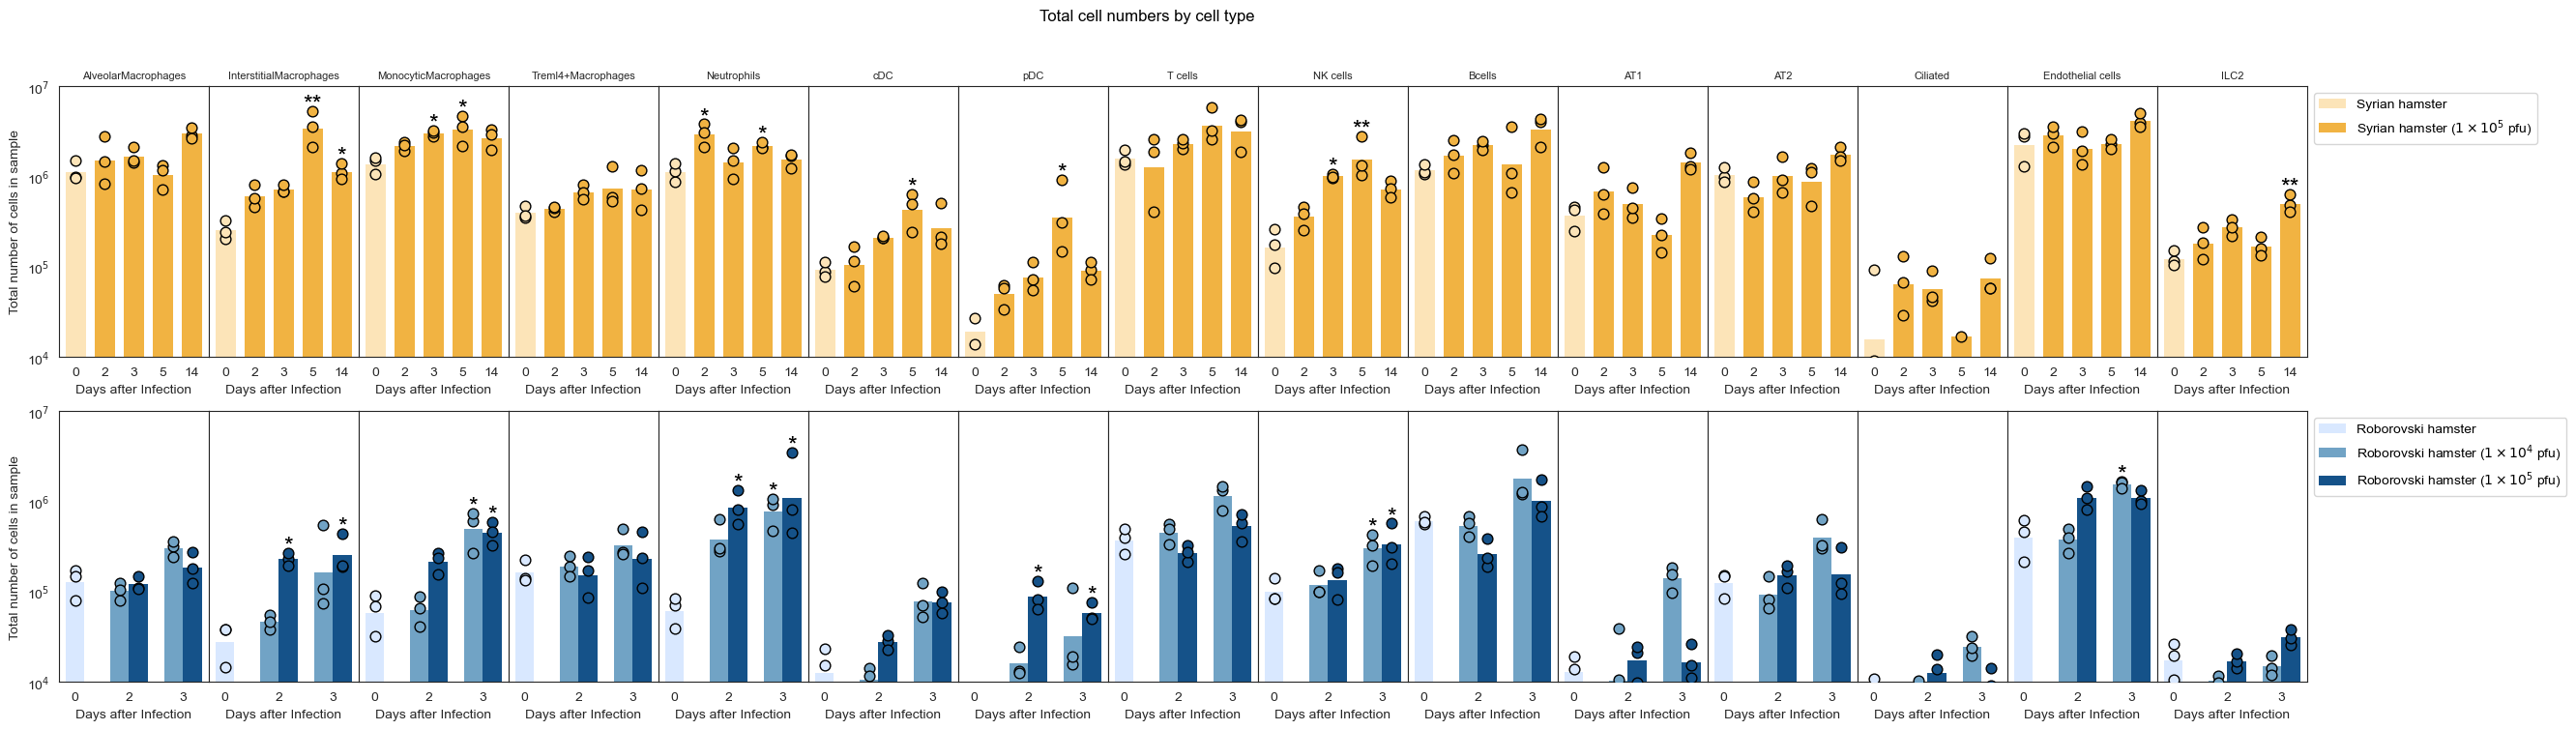

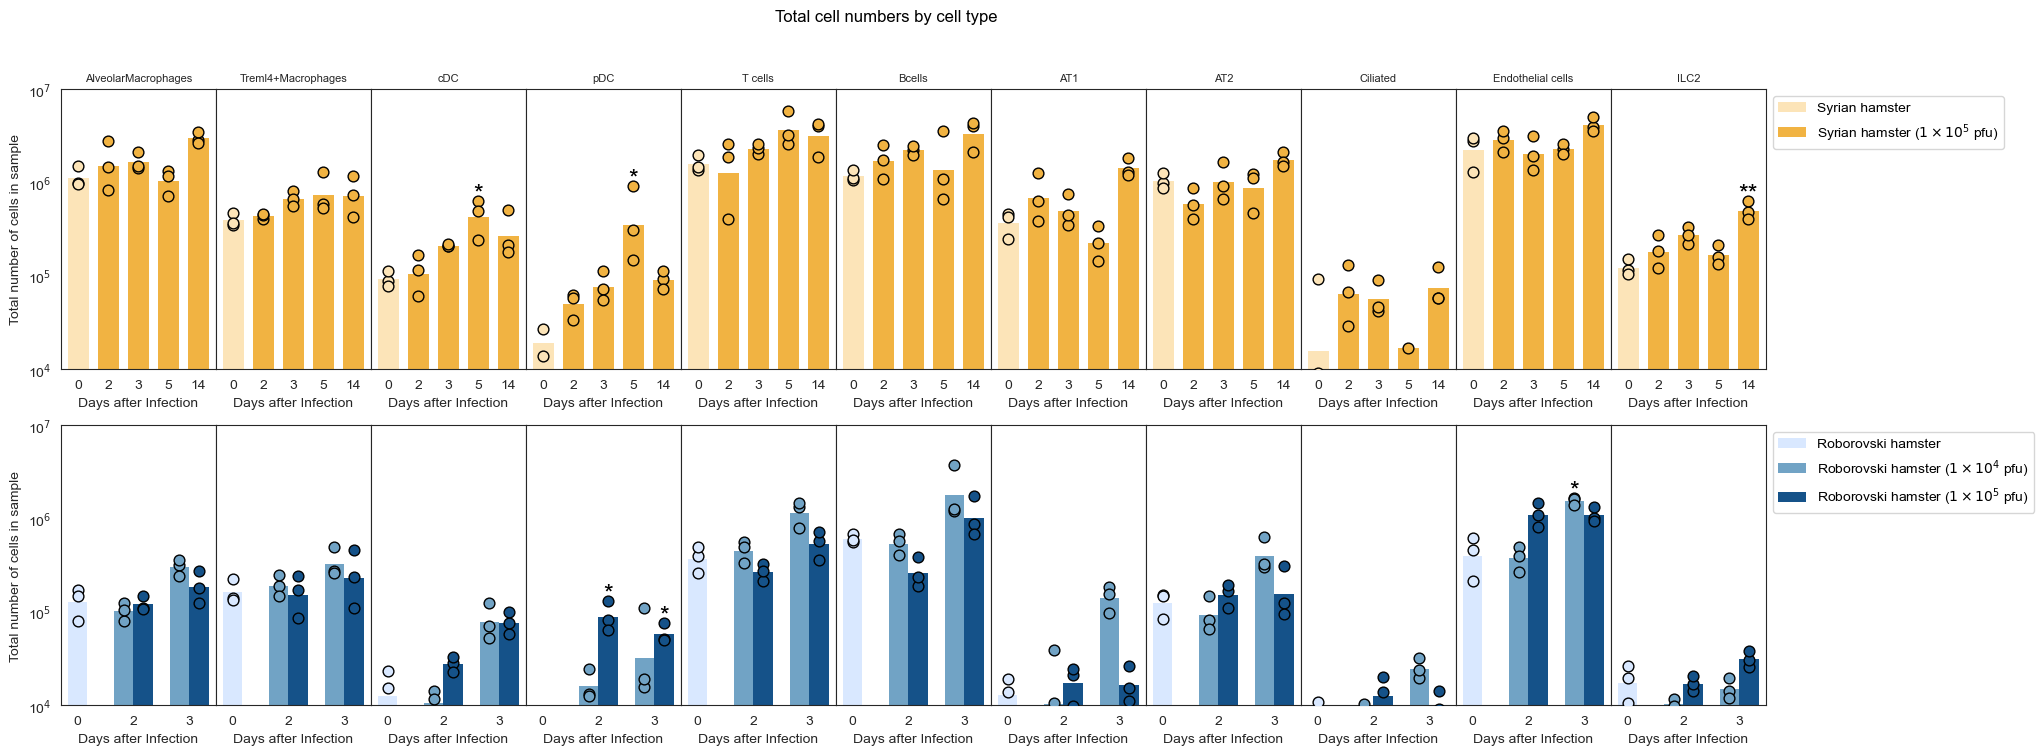

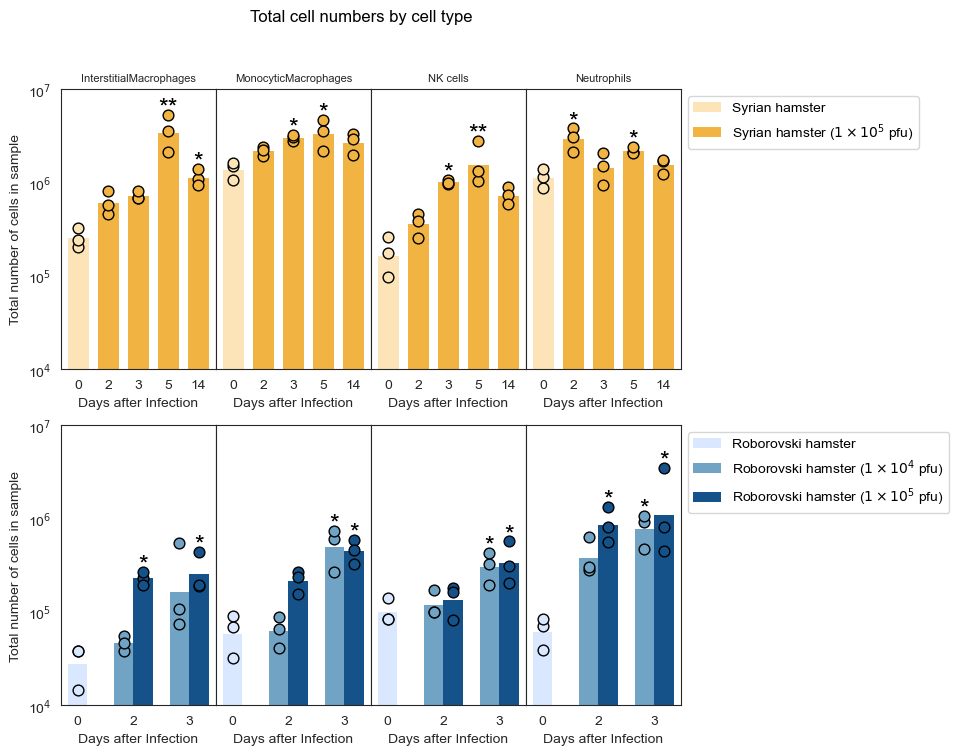

In [37]:
r1 = plot_cell_frequency_bars(main_celltypes, 'total_log10')
# pl.savefig(figure_path / 'Absolute_cell_numbers_by_celltype_logscale.pdf')
pl.show()

r2 = plot_cell_frequency_bars(['AlveolarMacrophages', 'Treml4+Macrophages', 'cDC', 'pDC', 'T cells', 'Bcells', 'AT1', 'AT2', 'Ciliated', 'Endothelial cells', 'ILC2'], 'total_log10')
# pl.savefig(figure_path / 'Absolute_cell_numbers_by_celltype_logscale_allexceptselection.pdf')
pl.show()

r3 = plot_cell_frequency_bars(['InterstitialMacrophages', 'MonocyticMacrophages', 'NK cells', 'Neutrophils'], 'total_log10')
# pl.savefig(figure_path / 'Absolute_cell_numbers_by_celltype_logscale_selection.pdf')
pl.show()

pd.concat([pd.DataFrame(r1).T, pd.DataFrame(r2).T, pd.DataFrame(r3).T], axis=0).to_csv(table_path / 'Fig2_statistics.csv')

#### relative

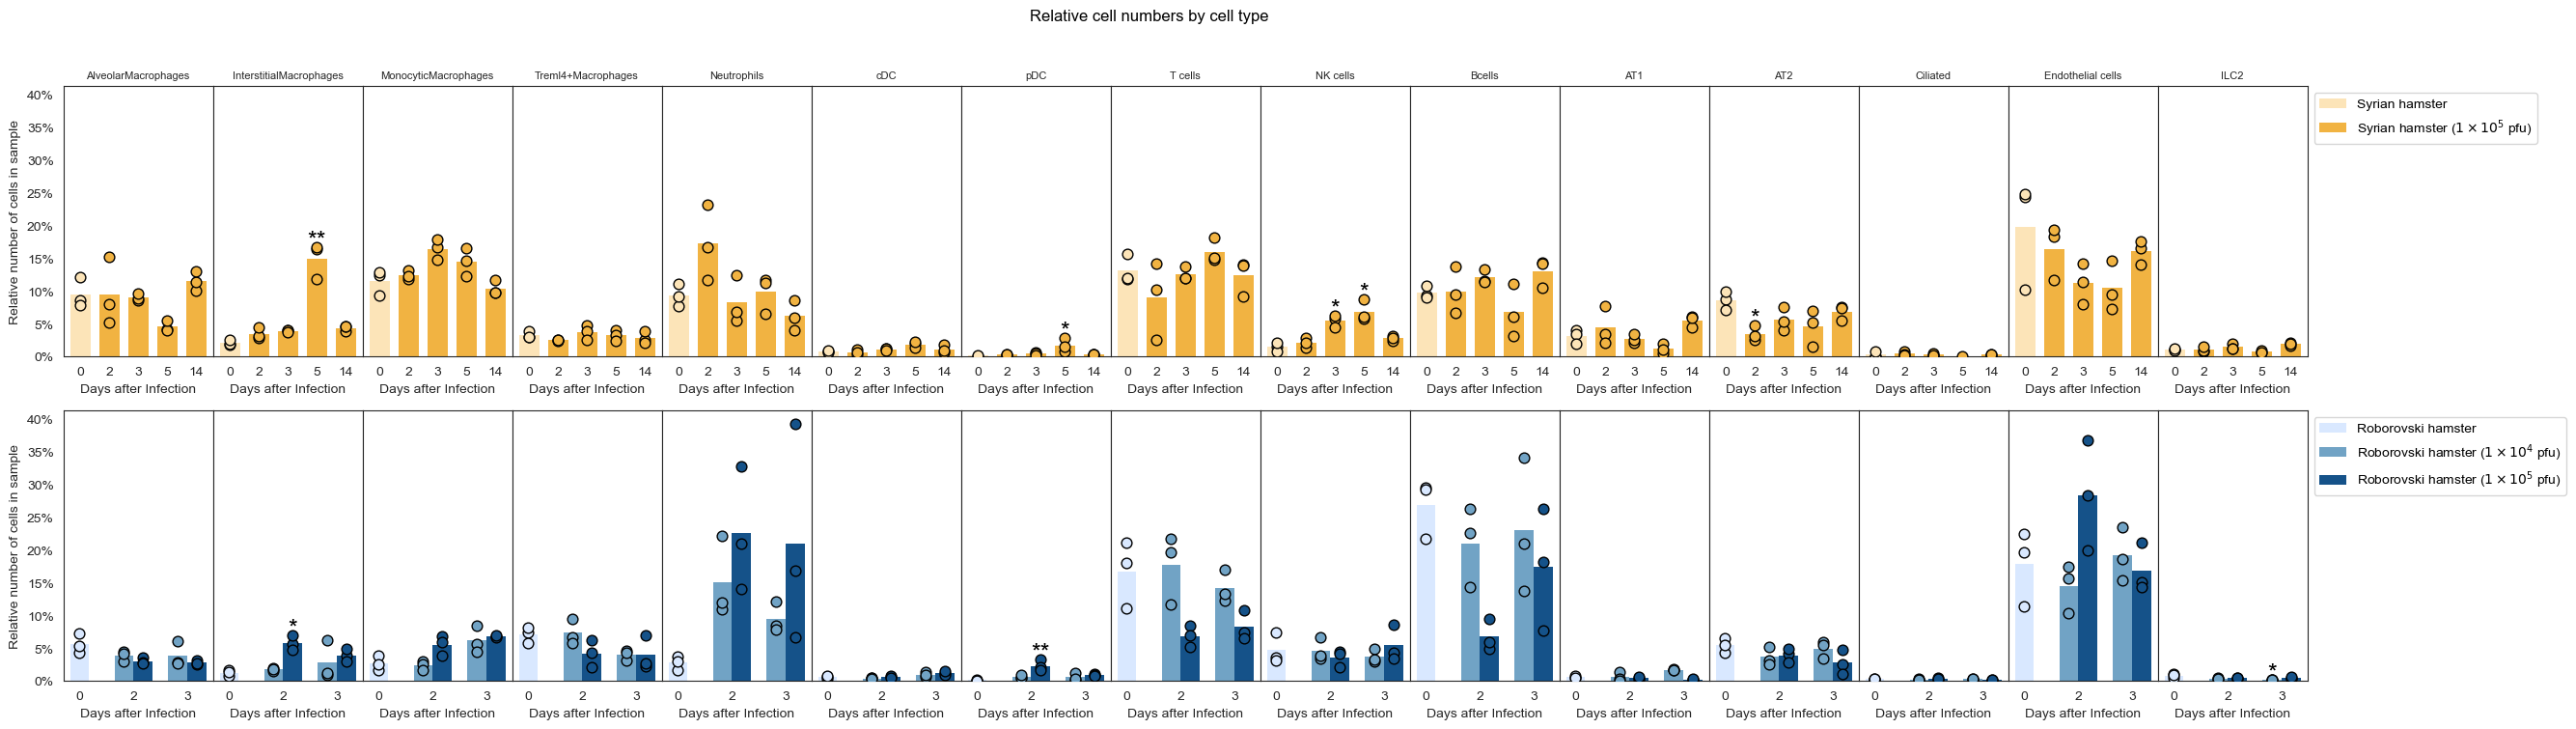

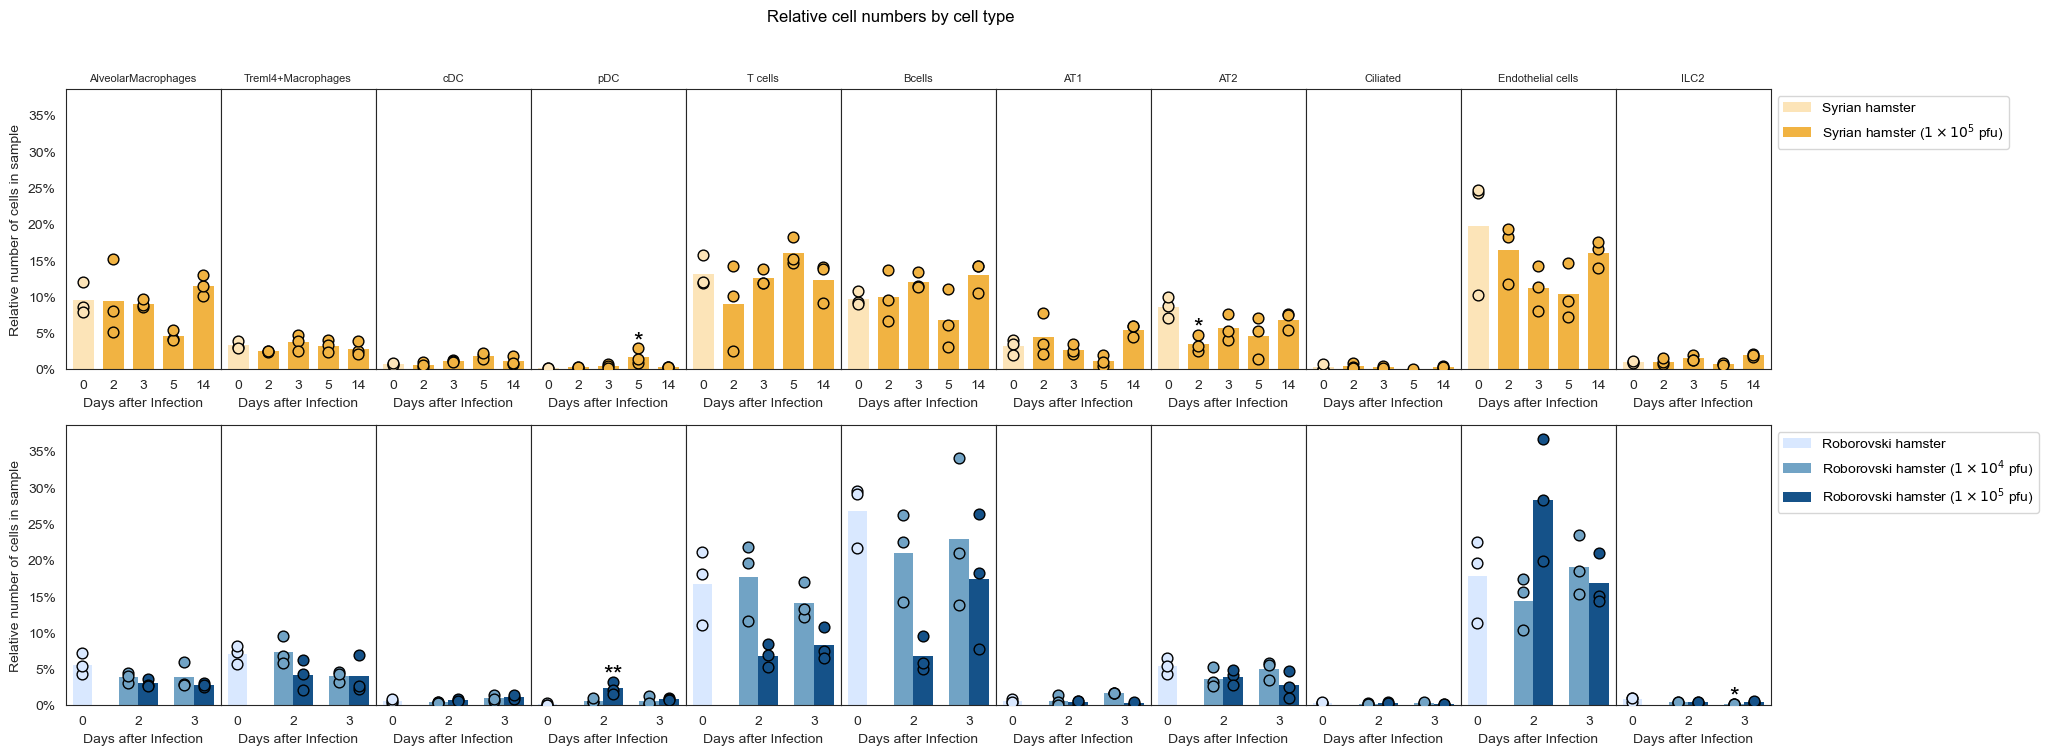

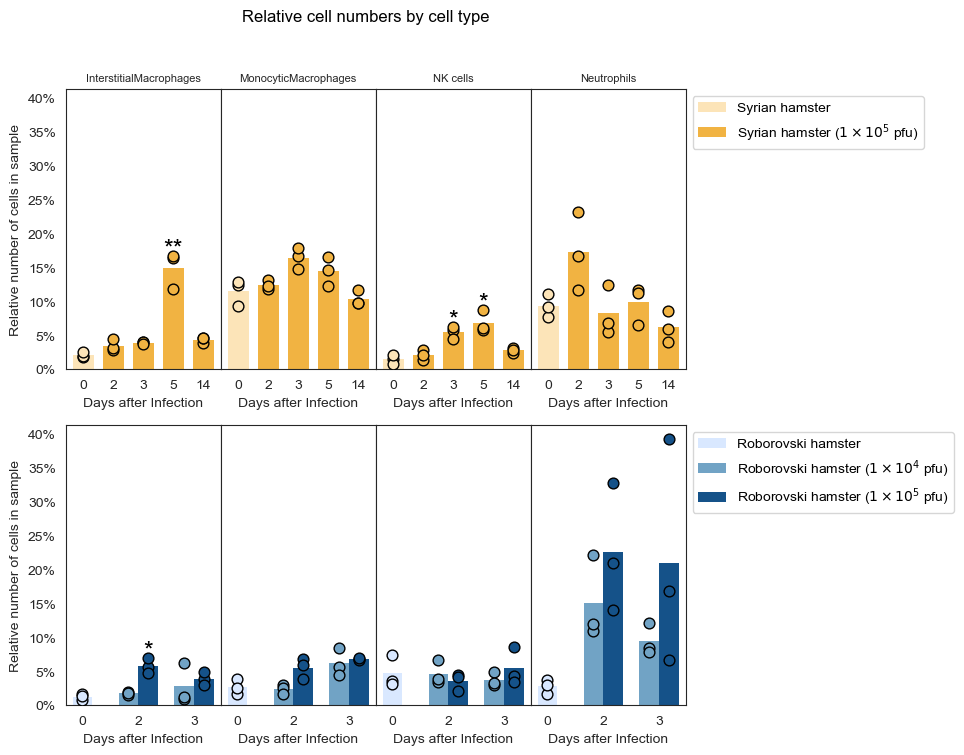

In [35]:
r1 = plot_cell_frequency_bars(main_celltypes, 'freq')
# pl.savefig(figure_path / 'Relative_cell_numbers_by_celltype.pdf', bbox_inches='tight')
pl.show()


r2 = plot_cell_frequency_bars(['AlveolarMacrophages', 'Treml4+Macrophages', 'cDC', 'pDC', 'T cells', 'Bcells', 'AT1', 'AT2', 'Ciliated', 'Endothelial cells', 'ILC2'], 'freq')
# pl.savefig(figure_path / 'Relative_cell_numbers_by_celltype_logscale_allexceptselection.pdf')
pl.show()

r3 = plot_cell_frequency_bars(['InterstitialMacrophages', 'MonocyticMacrophages', 'NK cells', 'Neutrophils'], 'freq')
# pl.savefig(figure_path / 'Relative_cell_numbers_by_celltype_selection.pdf', bbox_inches='tight')
pl.show()

pd.concat([pd.DataFrame(r1).T, pd.DataFrame(r2).T, pd.DataFrame(r3).T], axis=0).to_csv(table_path / 'Fig2_relative_statistics.csv')

### relative reordered

In [62]:
sdf = adfs[adfs['index']=='MonocyticMacrophages'].copy()
test_key = 'freq'
sdf.head()

,index,freq,total,organism,time,hamster,dummy,dose,total_log10
3,MonocyticMacrophages,0.092771,1.066867e+06,Goldhamster,D0,1,Goldhamster_D0,NaN,6.028110
22,MonocyticMacrophages,0.123920,1.524221e+06,Goldhamster,D0,2,Goldhamster_D0,NaN,6.183048
43,MonocyticMacrophages,0.128488,1.618951e+06,Goldhamster,D0,3,Goldhamster_D0,NaN,6.209234
65,MonocyticMacrophages,0.118531,1.943916e+06,Goldhamster,D2,1,Goldhamster_D2,NaN,6.288678
86,MonocyticMacrophages,0.132152,2.431598e+06,Goldhamster,D2,2,Goldhamster_D2,NaN,6.385892


In [64]:
# ANOVA if there is a difference in means between the different time points in Goldhamster
data = sdf
f_value, p_value = f_oneway(*[data[data.dummy==t][test_key] for t in pd.unique(data.dummy)])
anova_sig = p_value < 0.05
post_pvalues = posthoc_dunn(data, val_col=test_key, group_col='dummy', 
                    p_adjust=None)['Goldhamster_D0'][1:]  # only tests against D0
post_pvalues_corr = pd.Series(multipletests(post_pvalues, method='fdr_bh')[1], post_pvalues.index)

In [65]:
post_pvalues

Dwarfhamster_D2_high dose    0.114862
Dwarfhamster_D2_low dose     0.012273
Dwarfhamster_D3_high dose    0.227925
Dwarfhamster_D3_low dose     0.150550
Goldhamster_D0               1.000000
Goldhamster_D2               0.852840
Goldhamster_D3               0.286153
Goldhamster_D5               0.577878
Goldhamster_E14              0.676411
Name: Goldhamster_D0, dtype: float64

In [14]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [15]:
# two-way ANOVA
model = ols('freq ~ C(organism) + C(time)', data=sdf).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(organism),0.045692,1.0,184.532147,9.208162e-13
C(time),0.010248,4.0,10.347277,5.137430e-05
Residual,0.005943,24.0,NaN,NaN


In [48]:
post_pvalues = posthoc_dunn(data, val_col='freq', group_col='time', p_adjust=None)
post_pvalues

,D0,D2,D3,D5,E14
D0,1.000000,0.829357,0.326178,0.047561,0.391574
D2,0.829357,1.000000,0.180669,0.023096,0.280531
D3,0.326178,0.180669,1.000000,0.185090,0.894570
D5,0.047561,0.023096,0.185090,1.000000,0.330130
E14,0.391574,0.280531,0.894570,0.330130,1.000000


In [49]:
post_pvalues = posthoc_dunn(data, val_col='freq', group_col='organism', p_adjust=None)
post_pvalues

,Dwarfhamster,Goldhamster
Dwarfhamster,1.000000,0.000003
Goldhamster,0.000003,1.000000


In [50]:
post_pvalues = posthoc_dunn(data, val_col='freq', group_col='dummy', p_adjust=None)
post_pvalues

,Dwarfhamster_D0_no dose,Dwarfhamster_D2_high dose,Dwarfhamster_D2_low dose,Dwarfhamster_D3_high dose,Dwarfhamster_D3_low dose,Goldhamster_D0,Goldhamster_D2,Goldhamster_D3,Goldhamster_D5,Goldhamster_E14
Dwarfhamster_D0_no dose,1.000000,0.458098,0.852840,0.265720,0.378262,0.020412,0.012273,0.000711,0.004038,0.057259
Dwarfhamster_D2_high dose,0.458098,1.000000,0.353679,0.710644,0.889354,0.114862,0.078034,0.008210,0.032908,0.246315
Dwarfhamster_D2_low dose,0.852840,0.353679,1.000000,0.194126,0.286153,0.012273,0.007152,0.000356,0.002208,0.036904
Dwarfhamster_D3_high dose,0.265720,0.710644,0.194126,1.000000,0.816639,0.227925,0.164160,0.023067,0.078034,0.430488
Dwarfhamster_D3_low dose,0.378262,0.889354,0.286153,0.816639,1.000000,0.150550,0.104571,0.012273,0.046144,0.307621
Goldhamster_D0,0.020412,0.114862,0.012273,0.227925,0.150550,1.000000,0.852840,0.286153,0.577878,0.676411
Goldhamster_D2,0.012273,0.078034,0.007152,0.164160,0.104571,0.852840,1.000000,0.378262,0.710644,0.546601
Goldhamster_D3,0.000711,0.008210,0.000356,0.023067,0.012273,0.286153,0.378262,1.000000,0.609972,0.137818
Goldhamster_D5,0.004038,0.032908,0.002208,0.078034,0.046144,0.577878,0.710644,0.609972,1.000000,0.330130
Goldhamster_E14,0.057259,0.246315,0.036904,0.430488,0.307621,0.676411,0.546601,0.137818,0.330130,1.000000


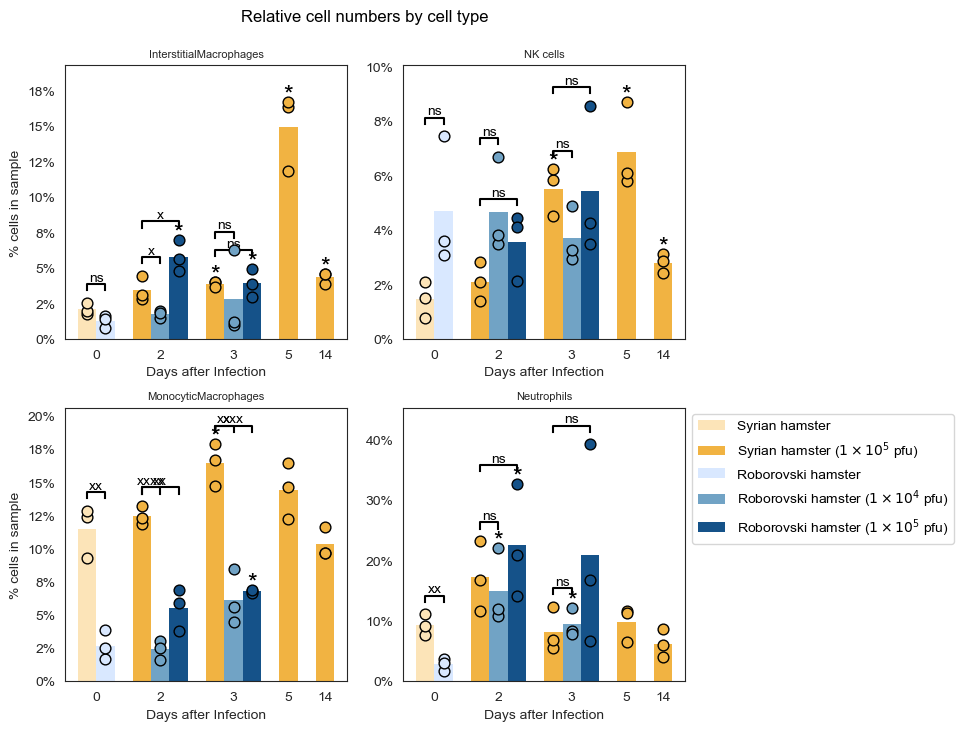

In [13]:
# rearranged freq
w_ = 0.3  # width of bars
selection = ['InterstitialMacrophages', 'NK cells', 'MonocyticMacrophages', 'Neutrophils']
# freqs
# distance between pvalue annotation and highest scatter point in plot
M = len(selection)

# statistical annotation
def annotate_significance(x1, x2, y, h, text, ax, **kwargs):
    """Add significance annotation to a plot."""
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
    ax.text((x1+x2)*.5, y+h, text, ha='center', va='bottom', color='k', **kwargs)

with sns.axes_style('white'):
    fig, axss = pl.subplots(2, 2, figsize=[2*4, 4*2], sharey=False)
axs = np.ravel(axss)
for celltype, ax, m in zip(selection, axs, np.arange(M)):

    sdf = adfs[adfs['index'] == celltype]
    ax.set_xticks(np.array([0.5, 4, 8, 11, 13])*w_)
    ax.set_xticklabels(['0', '2', '3', '5', '14'])

    for i, organism in enumerate(sdf.organism.unique()):
        # D0
        
        color=organism_dosage_colors[f'{organism}_no dose']
        ys = sdf[(sdf.organism == organism) & (sdf.time == 'D0')]['freq']
        x = [w_*i] * len(ys)
        ax.scatter(x, ys, c=color, **scatter_kwargs)
        ax.bar(x, ys.mean(), width=w_, color=color,
               label=sanitize_name(organism))

        # D2-D3
        for j, time in enumerate(['D2', 'D3']):
            if organism == 'Goldhamster':
                # Gold
                color=organism_dosage_colors[f'{organism}_high dose']
                ys = sdf[(sdf.organism == organism) & (
                    sdf.time == time)]['freq']
                x = [(4*j+3)*w_] * len(ys)
                ax.scatter(x, ys, color=color, **scatter_kwargs)
                ax.bar(x, ys.mean(), width=w_, color=color, 
                       label=r'Syrian hamster ($1 \times 10^5$ pfu)' if j == 0 else None)
                pv = test_fct(sdf[(sdf.organism==organism) & (sdf.time=='D0')]['freq'], 
                              sdf[(sdf.organism==organism) & (sdf.time==time)]['freq'])[1]
                if pv<0.05: ax.text(x[0], np.max(ys), '*', **pv_text_kwargs)
            else:
                # Dwarf low dose
                color=organism_dosage_colors[f'{organism}_low dose']
                ys = sdf[(sdf.organism == organism) & (
                    sdf.time == time) & (sdf.dose == 'low dose')]['freq']
                x = [(4*j+4)*w_] * len(ys)
                ax.scatter(x, ys, color=color, **scatter_kwargs)
                ax.bar(x, ys.mean(), width=w_, color=color, 
                       label=r'Roborovski hamster ($1 \times 10^4$ pfu)' if j == 0 else None)
                pv = test_fct(sdf[(sdf.organism==organism) & (sdf.time=='D0')]['freq'], 
                              sdf[(sdf.organism==organism) & (sdf.time==time) & (sdf.dose=='low dose')]['freq'])[1]
                if pv<0.05: ax.text(x[0], np.max(ys), '*', **pv_text_kwargs)
                
                # Dwarf high dose
                color=organism_dosage_colors[f'{organism}_high dose']
                ys = sdf[(sdf.organism == organism) & (
                    sdf.time == time) & (sdf.dose == 'high dose')]['freq']
                x = [(4*j+5)*w_] * len(ys)
                ax.scatter(x, ys, color=color, **scatter_kwargs)
                ax.bar(x, ys.mean(), width=w_, color=color, 
                       label=r'Roborovski hamster ($1 \times 10^5$ pfu)' if j == 0 else None)
                pv = test_fct(sdf[(sdf.organism==organism) & (sdf.time=='D0')]['freq'], 
                              sdf[(sdf.organism==organism) & (sdf.time==time) & (sdf.dose=='high dose')]['freq'])[1]
                if pv<0.05: ax.text(x[0], np.max(ys), '*', **pv_text_kwargs)
        
        if organism == 'Goldhamster':
            # D5, E14
            for j, time in enumerate(['D5', 'E14']):
                color=organism_dosage_colors[f'{organism}_high dose']
                ys = sdf[(sdf.organism == organism) & (
                    sdf.time == time)]['freq']
                x = [(2*j+11)*w_] * len(ys)
                ax.scatter(x, ys, color=color, **scatter_kwargs)
                ax.bar(x, ys.mean(), width=w_, color=color)
                pv = test_fct(sdf[(sdf.organism==organism) & (sdf.time=='D0')]['freq'], 
                              sdf[(sdf.organism==organism) & (sdf.time==time)]['freq'])[1]
                if pv<0.05: ax.text(x[0], np.max(ys), '*', **pv_text_kwargs)
    
    # extend y axis to fit all data
    ymin, ymax = ax.get_ylim()
    ax.set_ylim([ymin, ymax + 0.1 * (ymax-ymin)])
    
    # Statistical tests and annotations
    y1 = sdf[(sdf.organism == 'Goldhamster') & (sdf.time == 'D0')]['freq']
    y2 = sdf[(sdf.organism == 'Dwarfhamster') & (sdf.time == 'D0')]['freq']
    offset = (ymax-ymin)
    annotate_significance(0, w_, np.max([y1, y2]) + offset * 0.05, offset * 0.025, 
                          format_one_pval(test_fct(y1, y2)[1], 'x'), ax)
    
    for j, time in enumerate(['D2', 'D3']):
        y1 = sdf[(sdf.organism == 'Goldhamster') & (sdf.time == time)]['freq']
        y2 = sdf[(sdf.organism == 'Dwarfhamster') & (sdf.time == time) & (sdf.dose == 'low dose')]['freq']
        offset = (ymax-ymin)
        annotate_significance((4*j+3)*w_, (4*j+4)*w_, np.max([y1, y2]) + offset * 0.05, offset * 0.025, 
                            format_one_pval(test_fct(y1, y2)[1], 'x'), ax)
        y1 = sdf[(sdf.organism == 'Goldhamster') & (sdf.time == time)]['freq']
        y2 = sdf[(sdf.organism == 'Dwarfhamster') & (sdf.time == time) & (sdf.dose == 'high dose')]['freq']
        offset = (ymax-ymin)
        annotate_significance((4*j+3)*w_, (4*j+5)*w_, np.max([y1, y2]) + offset * 0.05, offset * 0.025, 
                            format_one_pval(test_fct(y1, y2)[1], 'x'), ax)
        
    
    if m%2 == 0:
        ax.set_ylabel(f'% cells in sample')
    ax.set_xlabel('Days after Infection')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
    ax.set_title(f'{celltype}', fontsize=8)
    if m == M-1:
        ax.legend()
        sns.move_legend(ax, bbox_to_anchor=(1, 1), loc='upper left')
    
# pl.tight_layout()
# pl.subplots_adjust(wspace=0)
pl.subplots_adjust(hspace=0.25)
pl.suptitle('Relative cell numbers by cell type', y=0.95)
pl.savefig(figure_path / 'Relative_cell_numbers_by_celltype_selection_rearranged.pdf',
           bbox_inches='tight')
pl.show()